Aim of Project: To identify outliers or irregular measurements in a Well log dataset using Machine Learning Algorithms (LSTM Autoencoders)

LSTM Autoencoders combine the powers of the LSTM (Long short term memory) and Autoencoders. Autoencoders are artificial neural networks which aim to reproduce a dataset by training a network which removes the noise from the original dataset. LSTMs are a type of recurrent neural network which has the ability to learn long term dependencies among the inputs. The outputs provided by the LSTM is not just a function of the current input but of the past inputs as well

Hypothesis: The general idea behind this project is since the LSTM autoencoders on a very simple level compares its current input with all past inputs. If the LSTM AE are fed log data in real-time. It should be able to identify new formations encoutered, odd measurements relative to the well being drilled and other possible anomalies

# Import Python Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib import pylab
import seaborn as sb

## Import Data into Pandas DataFrame

In [25]:
f = open('Well logs for SVM_CorrectedPhi.dat', 'r')
data = np.genfromtxt(f, skip_header=1) 
f.close()

In [26]:
log_data = pd.DataFrame(data, columns = ['Well', 'Depth','Gamma','RHOB','NPHI'])

## Select Well "1" from Dataframe

In [27]:
well1_data = log_data[log_data['Well'] == 1]

In [28]:
well1_data.drop(['Well'], axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Its always a good idea to Visualize the relationship between features so here is a pair plot of all the log features

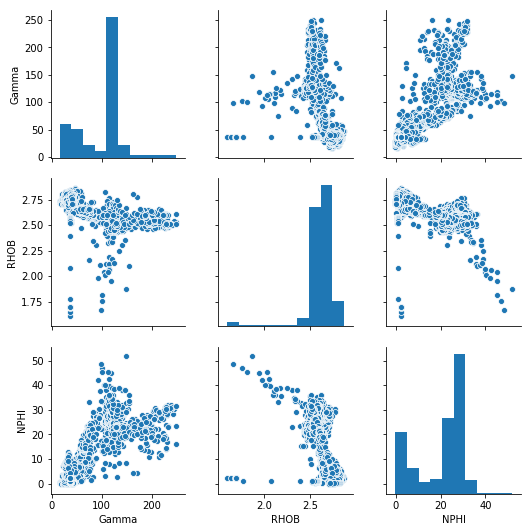

In [29]:
sb.pairplot(well1_data.iloc[:,1:])

## Scaling Well "1" Data

In [30]:
from sklearn.preprocessing import MinMaxScaler
transformer  = MinMaxScaler()
transformer.fit(well1_data.iloc[:,1:])
X_scale = transformer.transform(well1_data.iloc[:,1:])

## Importing Keras Libraries for the LSTM Autoencoders

In [31]:
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense

## We create a class which provides the losses before and after training each batch of the log features 

This loss value is used to identify the anomalies, with sudden large losses a sign of potential anomalies.

In [32]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses =[]
    def on_batch_end(self, batch, logs ={}):
        self.losses.append(logs.get('loss'))

# Preparing Model

In [33]:
depth_steps = 10 #Data is fed into the model in depthsteps, i.e the input includes 10sample points at a time. The numbers of samples per input depends on the user, the smaller the number the larger the sensitivity but will likely lead to more false alarms
dim = 3 #3-D inputs

lossHistory = LossHistory()

model = Sequential() 

model.add(LSTM(100, input_shape =(depth_steps, dim), return_sequences = True))
model.add(Dense(3))
model.compile(loss = 'mae', optimizer='adam')
#Function for training model and outputting results
def train(data):
    model.fit(data, data, epochs=1, batch_size = 1, validation_data = (data, data),verbose = 0, shuffle = False, callbacks= [lossHistory])
    
def score(data):
    yhat = model.predict(data)
    return yhat

## Function converts the Log data (input data) into 3D array to be fed to model

In [34]:
def create_true_input(df):
    length = len(np.array(df))
    trim = length % timesteps
    
    trimmed = np.array(df)[:len(df)-trim, :]
    
    trimmed.shape = (int(len(trimmed)/timesteps), timesteps, dim)
    
    return trimmed

# Function labels each data point as outlier or not based on results from model

In [35]:
def create_label(df,limit,loss):
    label = []
    for i in range(len(loss)):
        if loss[i] > limit:
            label.append(i)
    final_index = []
    for i in range(len(label)):
        temp = list(np.arange(label[i]*timesteps, (label[i]+1)*timesteps))
        final_index = final_index + temp
    anomaly_label = []
    for i in range(len(df)):
        if i in final_index:
            anomaly_label.append(1)
        else:
            anomaly_label.append(0)
    export_data = df
    export_data['Anomaly Label'] = anomaly_label
    
    return export_data

## Train Well "1" Data

In [36]:
trimmed = create_true_input(X_scale)

In [37]:
trimmed.shape

(797, 4, 3)

In [38]:
train(trimmed)

# Storing Losses from results

In [39]:
healthy_losses = lossHistory.losses

In [40]:
len(healthy_losses)

797

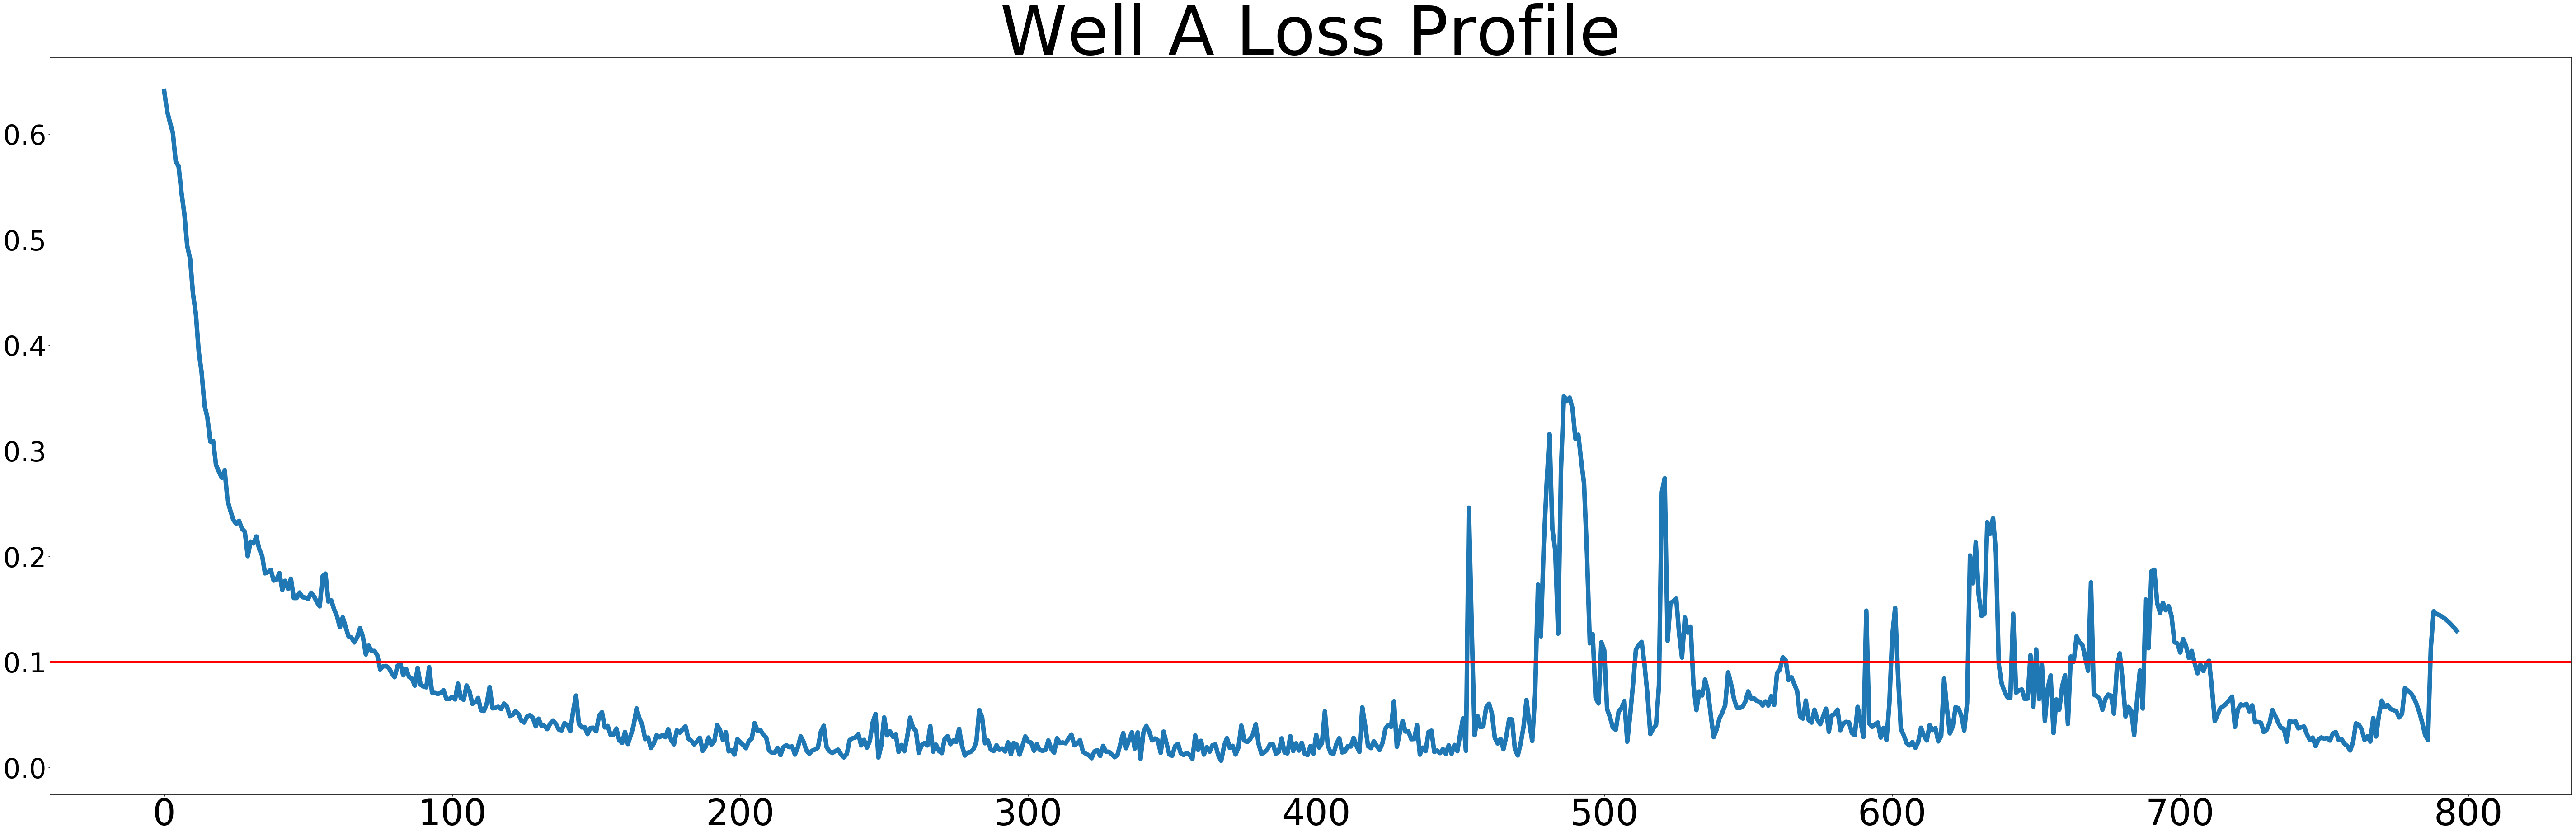

In [41]:
plt.figure(figsize=(100,30))
plt.plot(range(0,len(healthy_losses)), healthy_losses, linewidth = 10)
plt.axhline(y= 0.1, color = 'red', linewidth = 4)
plt.xticks(fontsize = 80)
plt.yticks(fontsize = 60)
plt.title('Well A Loss Profile', fontsize =150)
plt.savefig('Well A Loss Profile.png')

The loss limit is set by visual inspection, here we set the loss limit at 0.1 any depth step with error value greater than 0.1 is considered an anomaly.

# Labelling each sample point in Well "1"

In [46]:
new_export = create_label(well1_data,2,np.array(ratio))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0 represents the "INLIERS" while 1 represents "Outliers"

In [47]:
np.bincount(new_export['Anomaly Label'].values)

array([3058,  132])

In [23]:
new_export

,Depth,Gamma,RHOB,NPHI,Anomaly Label
0,2950.0,124.38150,2.57847,27.978,0
1,2950.5,129.87720,2.56771,27.280,0
2,2951.0,128.55070,2.55843,28.617,0
3,2951.5,132.77120,2.56048,28.506,0
4,2952.0,127.41270,2.55678,29.379,0
5,2952.5,127.39220,2.54694,29.018,0
6,2953.0,125.31670,2.54135,29.242,0
7,2953.5,127.96020,2.55632,28.728,0
8,2954.0,131.47330,2.59034,27.719,0
9,2954.5,131.49570,2.61276,26.922,0


## Preparing Well 2 Data

In [27]:
well2_data = log_data[log_data['Well'] == 2]

In [28]:
well2_data = well2_data.iloc[:,1:]

In [29]:
well2_data.dropna(inplace = True)

In [30]:
X2 = well2_data.iloc[:,1:]

## Visualizing relationship in Log features in Well "2"

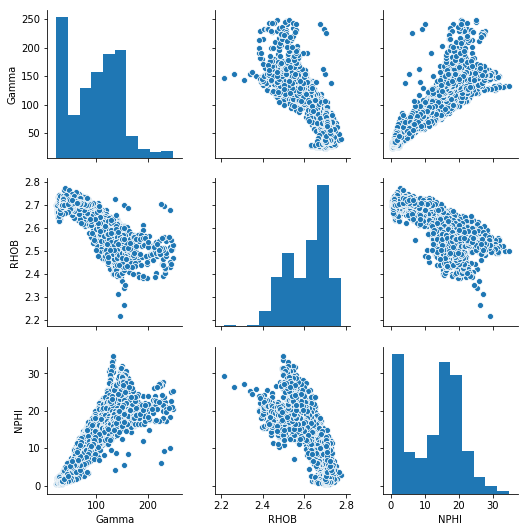

In [44]:
sb.pairplot(X2)

## Scaling Well B Data

In [32]:
transformer.fit(X2)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [33]:
X2_scale = transformer.transform(X2)

In [54]:
## Converting Input Data to a 3-D Array

In [34]:
trimmed_2 = create_true_input(X2_scale)

In [35]:
trimmed_2.shape

(264, 10, 3)

## Training Model with Well "2" Data

In [54]:
train(trimmed_2)

In [55]:
healthy_losses = lossHistory.losses

In [56]:
len(healthy_losses)

264

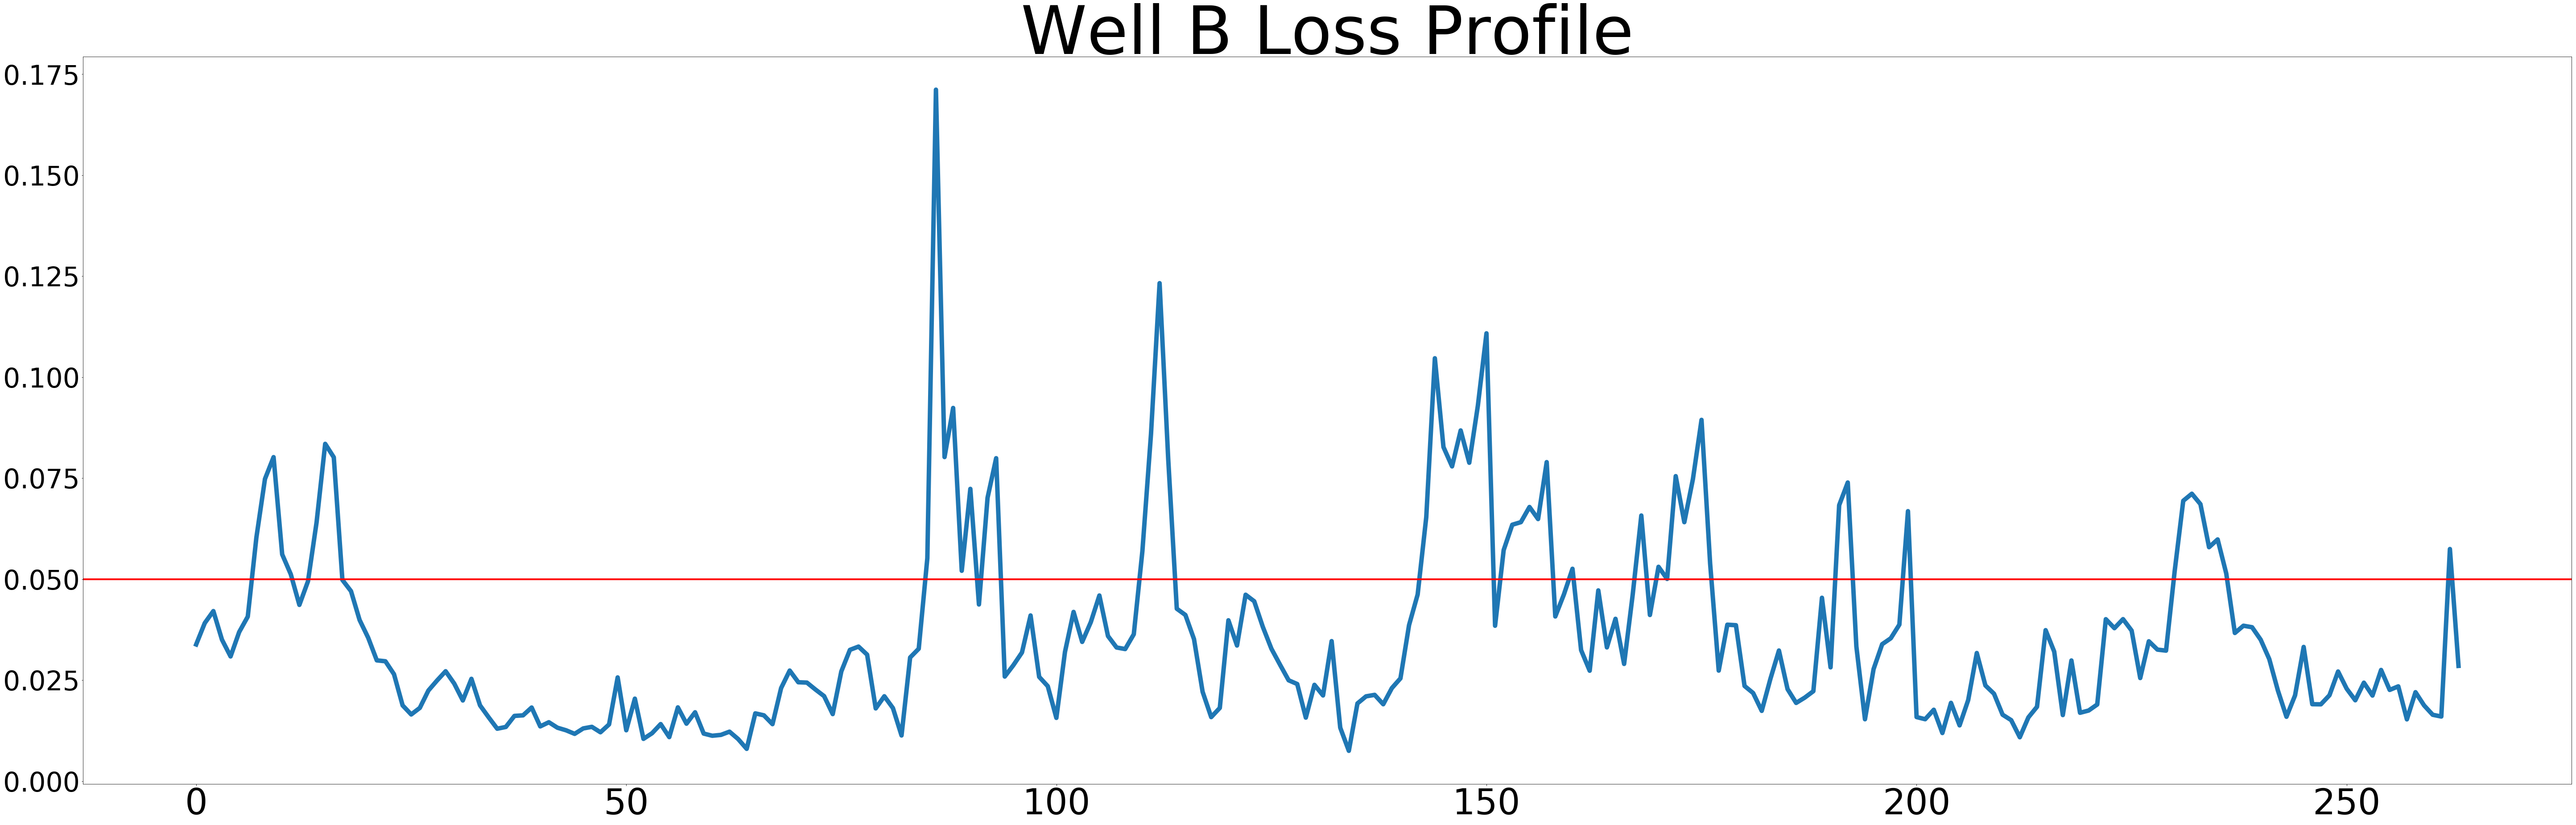

In [59]:
plt.figure(figsize=(100,30))
plt.plot(range(0,len(healthy_losses)), healthy_losses, linewidth = 10)
plt.axhline(y= 0.05, color = 'red', linewidth = 4)
plt.xticks(fontsize = 80)
plt.yticks(fontsize = 60)
plt.title('Well B Loss Profile', fontsize = 150)
plt.savefig('Well B Loss Profile.png')

In [ ]:
Los

## Labelling Each Sample in Well "2"

In [60]:
create_label(well2_data,0.05,healthy_losses)

,Depth,Gamma,RHOB,NPHI,Anomaly Label
3190,7300.5,139.50420,2.61307,16.884,0
3191,7301.0,139.43030,2.61587,16.961,0
3192,7301.5,140.48340,2.61889,17.131,0
3193,7302.0,139.43470,2.62321,17.306,0
3194,7302.5,139.69700,2.62104,17.484,0
3195,7303.0,137.96300,2.61798,17.887,0
3196,7303.5,138.18730,2.61944,18.125,0
3197,7304.0,138.19090,2.61466,18.254,0
3198,7304.5,139.04370,2.61296,17.533,0
3199,7305.0,139.60860,2.61054,17.495,0


([], <a list of 0 Text xticklabel objects>)

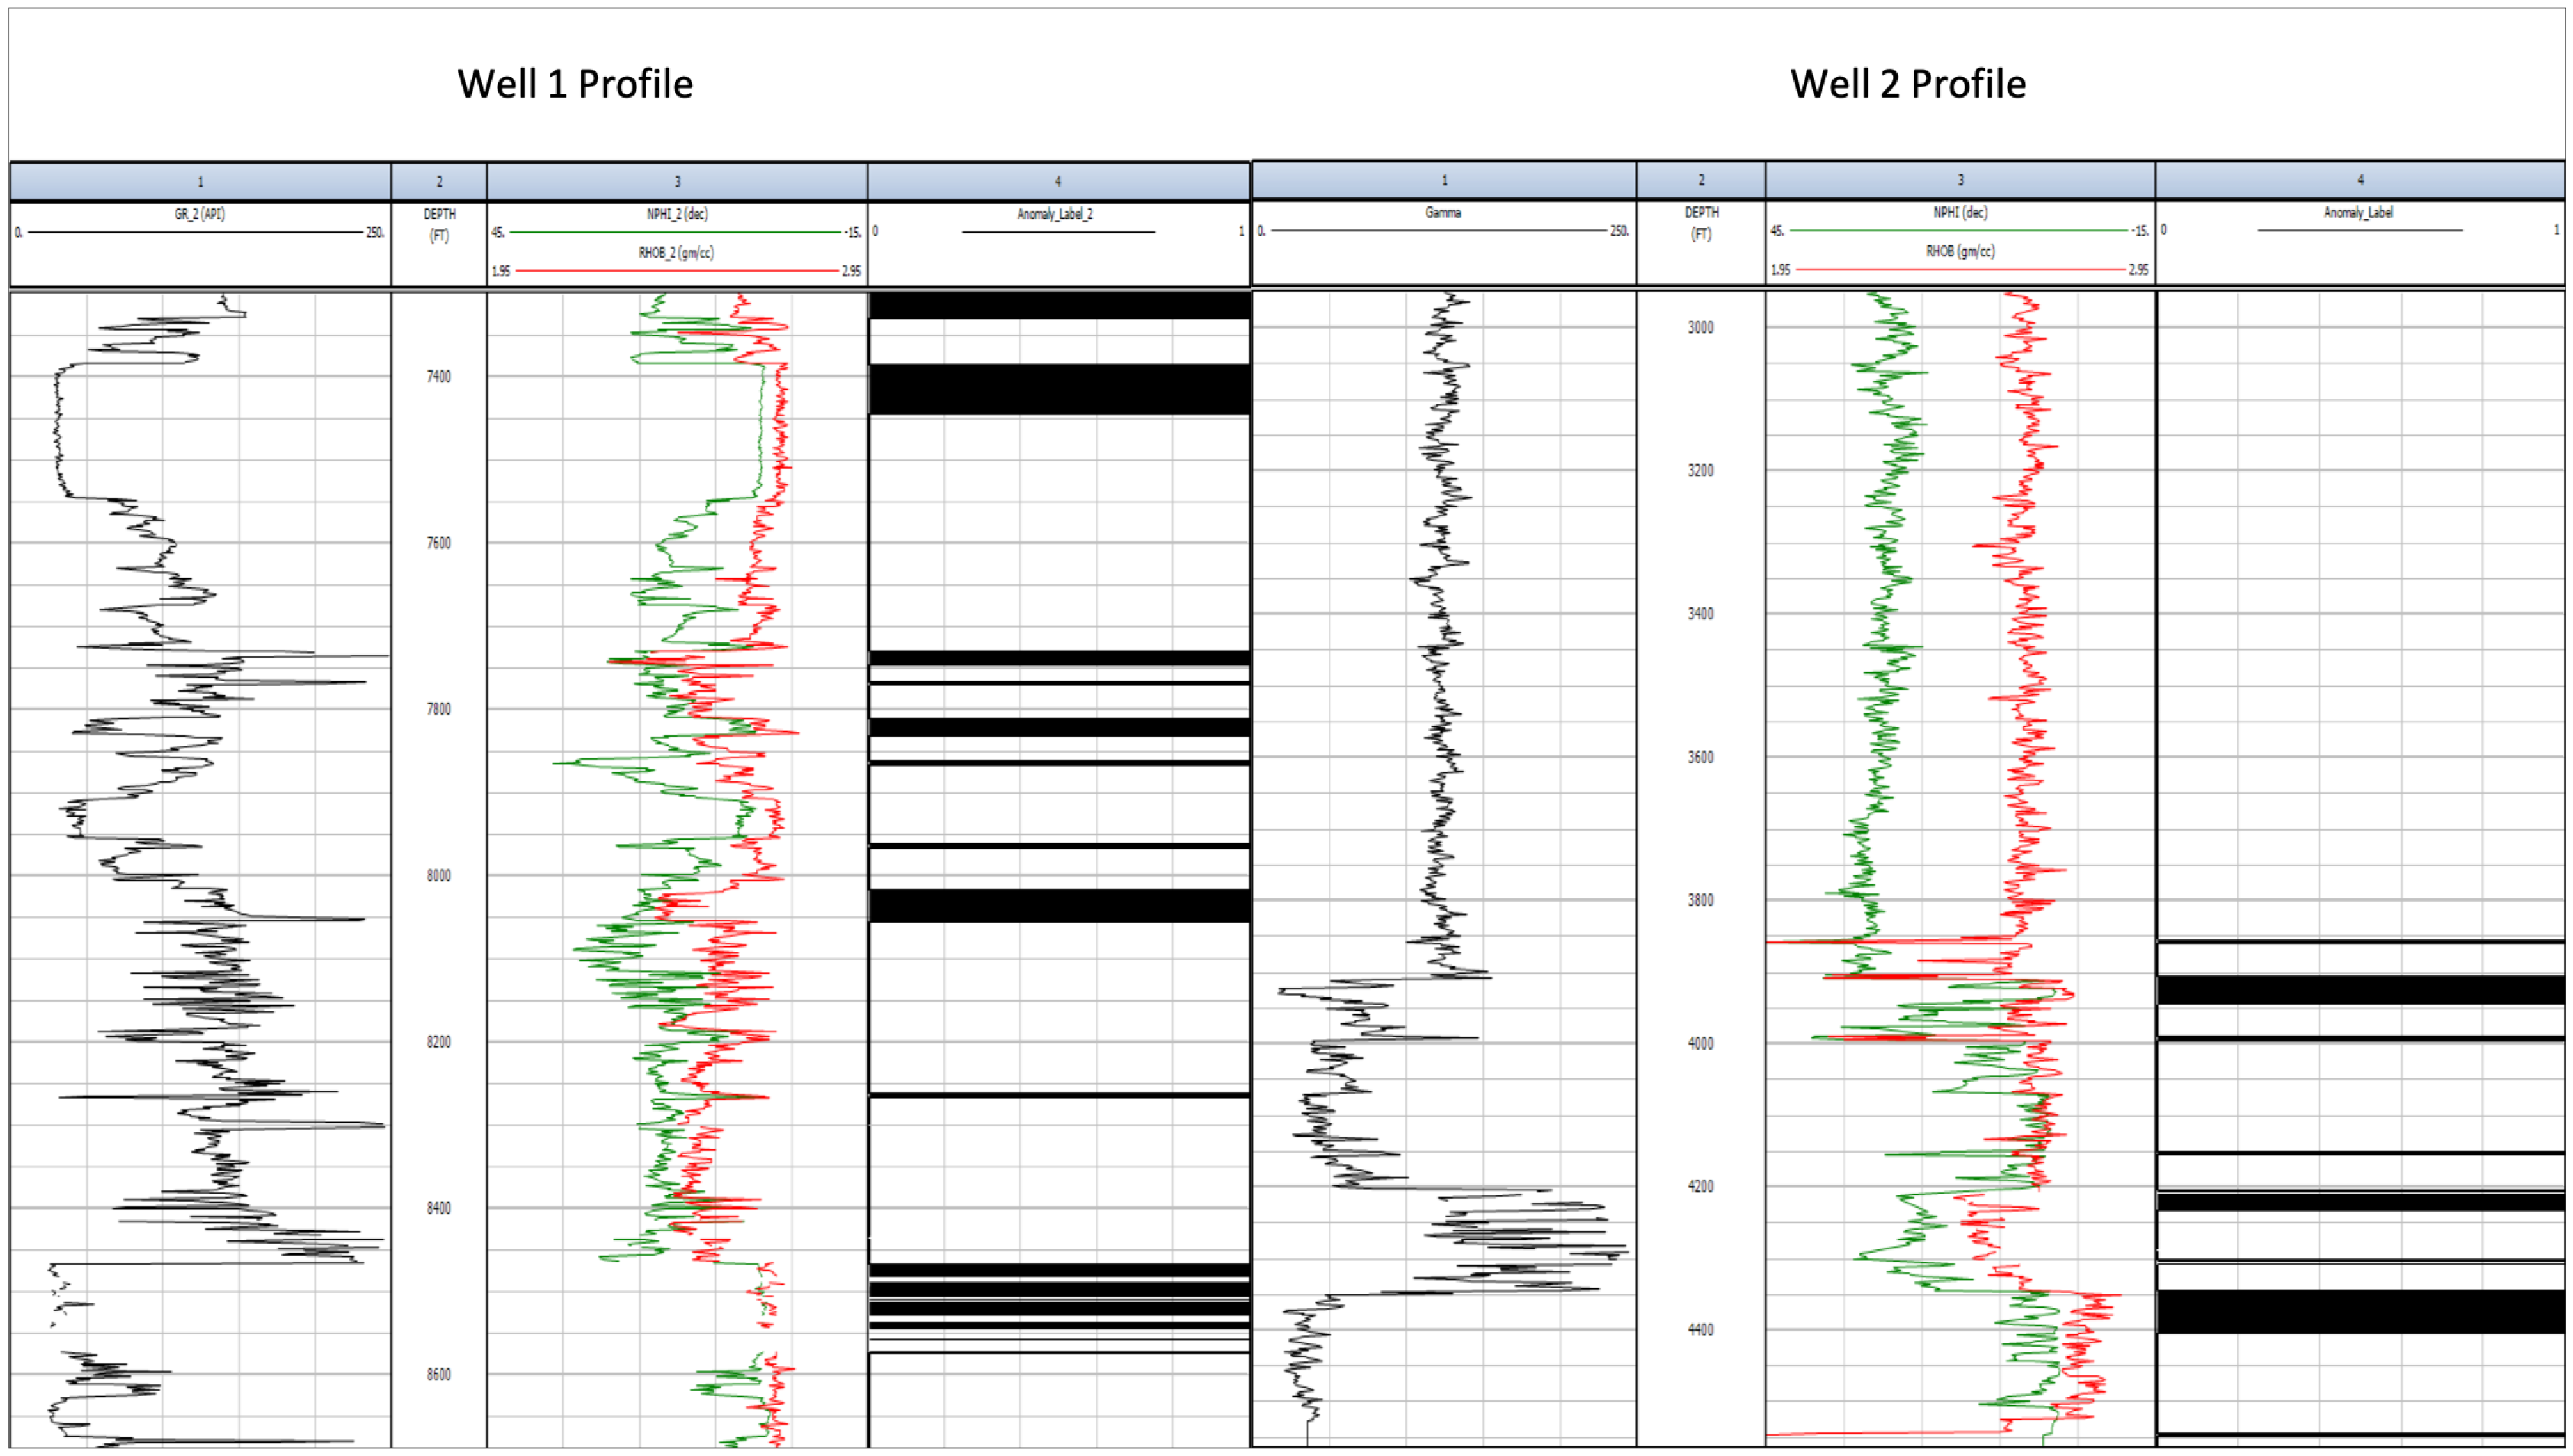

In [57]:
import matplotlib.image as mpimg
img1=mpimg.imread('Profiles.png')
plt.figure(figsize=(60,115))
imgplot = plt.imshow(img1)
plt.yticks([])
plt.xticks([])

The bar like black lines represents possible anomaolies and change in formation. If the profiles are carefully looked at the anomaly bars appear either during sharp changes in the well logs or where the formation changes as indicated by the reading from the gamma ray log.
When the model sees a new formation it flags a possible anomaly, after a while it stops as the model "remembers" that formation.

The main advantage of this is that it can be applied in real-time application, data can be fed into the model instantaneously with the model outputing the losses. It can be used in identifying the new formations when drilling or identifying anomalous signals from an LWD devices and much more.

Thank you for reading! If you have any questions. Feel free to mail me at oghenekaro.j.osogba@tamu.edu or on Linkedin on Oghenekaro Osogba